In [1]:
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10

Aнимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [2]:
32*32*3

3072

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



# DATASET

### Augmentation

In [4]:
# augm_transf = [torchvision.transforms.RandomHorizontalFlip(p=0.5),
#                                   torchvision.transforms.RandomRotation(degrees=45)]

In [5]:
# augm = torchvision.transforms.RandomApply(augm_transf, p=0.5)

In [6]:
transform = transforms.Compose(
    [
#         augm, 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2, )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [7]:
d = iter(trainloader)

In [8]:
sample = next(d)

In [9]:
type(sample), len(sample)

(list, 2)

In [10]:
sample[0].shape, sample[1].shape
# 4 - batch size
# 3 - канала изображения
# 32x32 - размер изображения

# 4 - target, размером с batch size

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [11]:
print(sample[0][0, 1, :,:].shape)
sample[0][0, 1, :,:]  # тут один из каналов изображение, нормализованное вокруг 0

torch.Size([32, 32])


tensor([[-0.0745,  0.0510, -0.0196,  ..., -0.1294, -0.0667, -0.3255],
        [-0.0039,  0.1843,  0.1059,  ..., -0.0510,  0.0510, -0.4275],
        [-0.0510, -0.0745,  0.0824,  ..., -0.2314, -0.0745, -0.3804],
        ...,
        [ 0.0431,  0.1059, -0.0510,  ..., -0.0980, -0.0275, -0.1608],
        [ 0.1216,  0.0588, -0.0275,  ..., -0.1765, -0.1373, -0.3176],
        [-0.2706, -0.3490, -0.3333,  ..., -0.5216, -0.5137, -0.6000]])

In [12]:
sample[0].shape

torch.Size([4, 3, 32, 32])

In [13]:
sample[0][2, :, :, :]  # 3 канала изображения

tensor([[[-0.5059, -0.4588, -0.4196,  ..., -0.5373, -0.5765, -0.6784],
         [-0.4431, -0.4196, -0.3882,  ..., -0.5373, -0.5608, -0.5686],
         [-0.4588, -0.4275, -0.3725,  ..., -0.4980, -0.5294, -0.5608],
         ...,
         [ 0.2706,  0.4196,  0.4745,  ...,  0.3725,  0.0588, -0.5216],
         [ 0.2706,  0.4510,  0.3725,  ...,  0.2941, -0.0902, -0.5608],
         [ 0.1216,  0.3647,  0.3098,  ...,  0.0588, -0.3098, -0.6157]],

        [[-0.5686, -0.5294, -0.4824,  ..., -0.6078, -0.6471, -0.7412],
         [-0.5059, -0.4745, -0.4510,  ..., -0.6235, -0.6471, -0.6549],
         [-0.5216, -0.4902, -0.4353,  ..., -0.6078, -0.6314, -0.6627],
         ...,
         [ 0.1922,  0.3333,  0.3882,  ...,  0.3255,  0.0118, -0.5529],
         [ 0.2078,  0.3882,  0.3098,  ...,  0.2392, -0.1373, -0.6000],
         [ 0.0902,  0.3333,  0.2706,  ..., -0.0039, -0.3569, -0.6471]],

        [[-0.5843, -0.5373, -0.4980,  ..., -0.6235, -0.6627, -0.7569],
         [-0.5216, -0.4980, -0.4667,  ..., -0

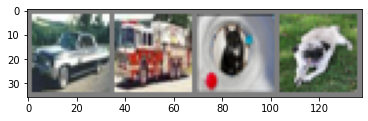

  car truck   cat   dog


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # меняем порядок каналов для pytorch
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

Конволюция - выделение из изображения важных частей. Мы можем как сжать изображение, так и увеличить размерность. Это помощь для нейронки. Чисто визуально мы ухудшаем качество, но выходное изображение содержит в себе некую информацию. Смотри [другой ноутбук](Свертки_и_пуллинг.ipynb)

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



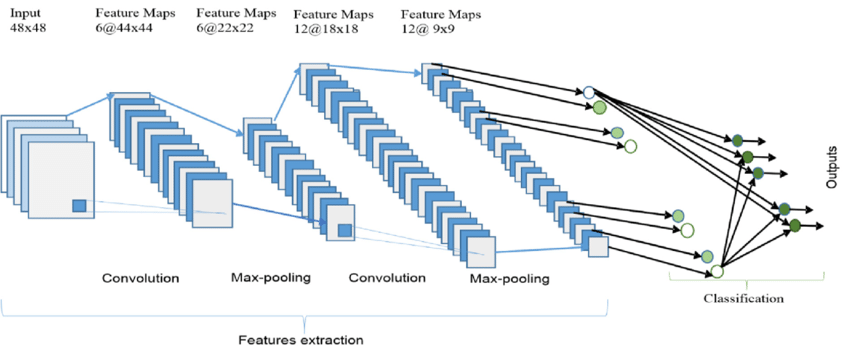

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # 32x32
        self.conv1 = nn.Conv2d(3, 6, 5)  # 28x28
        self.pool = nn.MaxPool2d(2, 2)  # 14x14
        self.conv2 = nn.Conv2d(6, 16, 5)  # 10x10 -> 5x5
        self.conv3 = nn.Conv2d(16, 32, 3)  # 5x5 -> 3x3
        self.fc1 = nn.Linear(32 * 3 * 3, 120)  # уменьшаем число нейронов
        self.fc2 = nn.Linear(120, 84)  # ещё меньшаем
        self.fc3 = nn.Linear(84, 10)  # уменьшаем до 10 - до числа классов
        # важно, чтобы входы и выходы совпадали

    def forward(self, x):  # как мы будем проходить нейронку вперёд
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 32 * 3 * 3)  # reshape
        x = F.relu(self.fc1(x))  # передаём на полносвязные слои
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # 10 значений, которые будут отвечать за класс
    
    # обратный путь определить сам pytorch

In [16]:
net = Net()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # стохастический градиентный спуск

## 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [18]:
EPOCH = 1
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)  # как будто просто создание класса, но это вызов
        
        loss = criterion(outputs, labels)
#         print(loss, outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

c:\users\rc199\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.303
[1,  4000] loss: 2.242
[1,  6000] loss: 1.943
[1,  8000] loss: 1.791
[1, 10000] loss: 1.703
[1, 12000] loss: 1.623
Finished Training


Let's quickly save our trained model:



In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



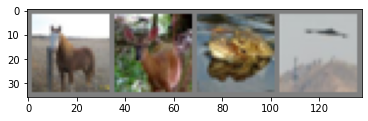

GroundTruth:  horse  deer  frog plane


In [21]:
# dataiter = iter(testloader)  # итератор для тестовой выборки
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [23]:
outputs = net(images)

In [24]:
outputs.shape
# 4 изображения
# выводятся просто значения, на основании их с помощью softmax считаем вероятности для каждого из 10 классов

torch.Size([4, 10])

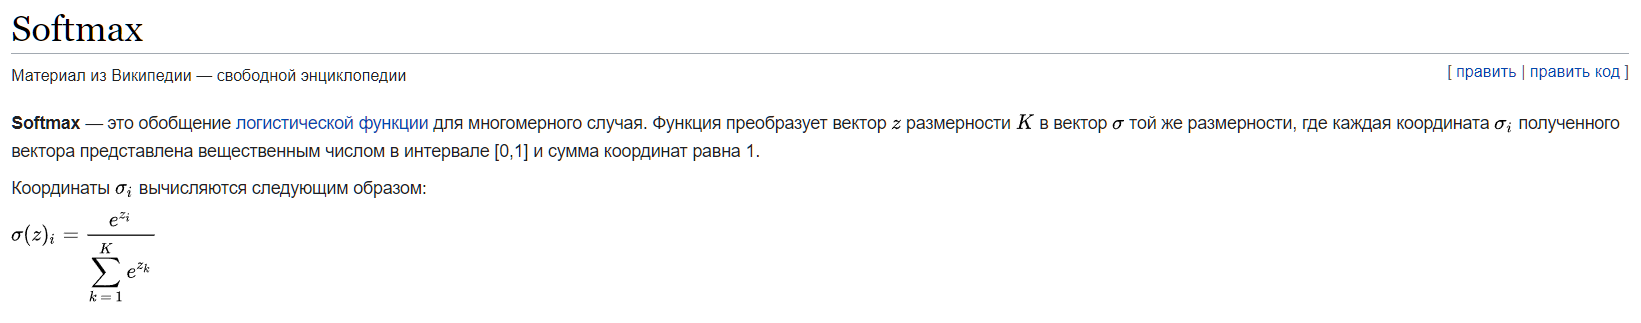

In [25]:
outputs

tensor([[ 0.1955, -0.5007, -0.0195,  0.0039, -0.2638, -0.1871, -1.5752,  1.7875,
         -0.6818,  0.9287],
        [-1.7339, -1.5427, -0.2433,  1.8875, -0.3647,  1.9570,  0.3048,  1.8065,
         -2.3126,  0.0384],
        [-0.9200,  0.4122,  0.0071,  0.2971,  0.3875, -0.2715,  1.1992, -0.8295,
         -0.9338,  0.2057],
        [ 1.5775, -1.6779,  1.6580,  0.7145,  0.2382,  0.2472, -1.7829, -0.5213,
          0.5841, -1.5072]], grad_fn=<AddmmBackward>)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [26]:
_, predicted = torch.max(outputs, 1)

In [27]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [28]:
predicted

tensor([7, 5, 6, 2])

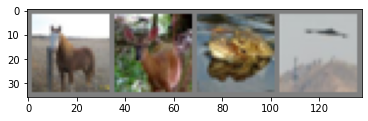

Predicted:  horse   dog  frog  bird


In [29]:
# print images
# GroundTruth:   frog truck   dog  frog
imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data  # получили изображения и метки
        outputs = net(images)  # получили ответы от нейронки
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # считаем, сколько правильно ответили

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# тут определяем корректность для каждого класса

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 70 %
Accuracy of  bird :  9 %
Accuracy of   cat : 24 %
Accuracy of  deer : 29 %
Accuracy of   dog : 57 %
Accuracy of  frog : 55 %
Accuracy of horse : 54 %
Accuracy of  ship : 40 %
Accuracy of truck : 51 %


**Как мы можем улучшить сеть?**
- увеличить число эпох на обучение (но мы уменьшили, чтобы не так долго было)
- уменьшить learning rate

    Комбинация этих параметров даст число шагов, кототорые пройдёт нейронка до окончания обучения
    
    
- изменить архитектуру сети

# ДЗ

Поиграться с параметрами **epoch**, **lr** и **momentum**, попробовать другой **optimizer**, чтобы добиться качества на тесте от 60%

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # на входе 32x32
        self.conv1 = nn.Conv2d(3, 6, 5)  # 28x28
        self.pool = nn.MaxPool2d(2, 2)  # 14x14
        self.conv2 = nn.Conv2d(6, 16, 5)  # 10x10 -> 5x5
        self.conv3 = nn.Conv2d(16, 32, 3)  # 5x5 -> 3x3
        self.fc1 = nn.Linear(32 * 3 * 3, 120)  # уменьшаем число нейронов
        self.fc2 = nn.Linear(120, 84)  # ещё меньшаем
        self.fc3 = nn.Linear(84, 10)  # уменьшаем до 10 - до числа классов
        # важно, чтобы входы и выходы совпадали

    def forward(self, x):  # как мы будем проходить нейронку вперёд
        # x = 32x32
        x = F.relu(self.pool(F.relu(self.conv1(x)))) # 32x32 -> 28x28 -> non-linear -> 14x14 -> non-linear
        x = F.relu(self.pool(F.relu(self.conv2(x)))) # 14x14 -> 10x10 -> non-linear -> 5x5 -> non-linear
        x = F.relu(F.relu(self.conv3(x))) # 5x5 -> 3x3 -> non-linear -> non-linear
        x = x.view(-1, 32 * 3 * 3)  # reshape
        x = F.relu(self.fc1(x))  # передаём на полносвязные слои
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # 10 значений, которые будут отвечать за класс
    
    # обратный путь определить сам pytorch

In [36]:
net = Net()

In [37]:
criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8, nesterov=True)

In [38]:
EPOCH = 5
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)  # как будто просто создание класса, но это вызов
        loss = criterion(outputs, labels)
#         print(loss, outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.291
[1,  6000] loss: 2.104
[1,  8000] loss: 1.982
[1, 10000] loss: 1.848
[1, 12000] loss: 1.776
[2,  2000] loss: 1.679
[2,  4000] loss: 1.635
[2,  6000] loss: 1.589
[2,  8000] loss: 1.535
[2, 10000] loss: 1.504
[2, 12000] loss: 1.455
[3,  2000] loss: 1.421
[3,  4000] loss: 1.382
[3,  6000] loss: 1.376
[3,  8000] loss: 1.342
[3, 10000] loss: 1.347
[3, 12000] loss: 1.322
[4,  2000] loss: 1.263
[4,  4000] loss: 1.250
[4,  6000] loss: 1.236
[4,  8000] loss: 1.272
[4, 10000] loss: 1.220
[4, 12000] loss: 1.231
[5,  2000] loss: 1.178
[5,  4000] loss: 1.184
[5,  6000] loss: 1.176
[5,  8000] loss: 1.128
[5, 10000] loss: 1.160
[5, 12000] loss: 1.124
Finished Training


In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data  # получили изображения и метки
        outputs = net(images)  # получили ответы от нейронки
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # считаем, сколько правильно ответили

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [40]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# тут определяем корректность для каждого класса

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 65 %
Accuracy of  bird : 46 %
Accuracy of   cat : 28 %
Accuracy of  deer : 49 %
Accuracy of   dog : 68 %
Accuracy of  frog : 47 %
Accuracy of horse : 67 %
Accuracy of  ship : 65 %
Accuracy of truck : 71 %


In [49]:
net = Net()

criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.ASGD(net.parameters(), lr=0.01, lambd=0.00001, alpha=0.6, t0=1000000.0, weight_decay=0)

EPOCH = 2
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)  # как будто просто создание класса, но это вызов
        loss = criterion(outputs, labels)
#         print(loss, outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data  # получили изображения и метки
        outputs = net(images)  # получили ответы от нейронки
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # считаем, сколько правильно ответили

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  2000] loss: 2.299
[1,  4000] loss: 2.082
[1,  6000] loss: 1.861
[1,  8000] loss: 1.731
[1, 10000] loss: 1.643
[1, 12000] loss: 1.578
[2,  2000] loss: 1.518
[2,  4000] loss: 1.491
[2,  6000] loss: 1.455
[2,  8000] loss: 1.430
[2, 10000] loss: 1.411
[2, 12000] loss: 1.381
Finished Training
Accuracy of the network on the 10000 test images: 51 %


In [50]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# тут определяем корректность для каждого класса

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 59 %
Accuracy of  bird : 26 %
Accuracy of   cat : 26 %
Accuracy of  deer : 51 %
Accuracy of   dog : 40 %
Accuracy of  frog : 70 %
Accuracy of horse : 66 %
Accuracy of  ship : 51 %
Accuracy of truck : 59 %
